In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.ch_4 import *

## Classifying Images ##

**Data Generation**

In [2]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

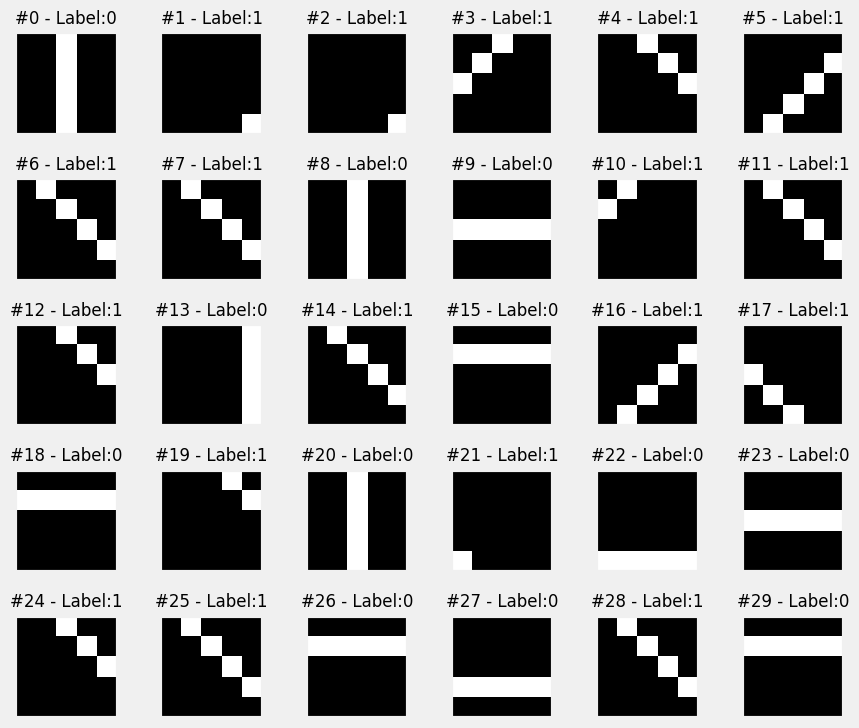

In [3]:
fig = plot_images(images, labels, n_plot=30)

## Images and Channels ##

In [4]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128
print(image_r)

[[255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]]


In [5]:
image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128
print(image_g)

[[  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]]


In [6]:
image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255
print(image_b)

[[  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]]


In [7]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [8]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

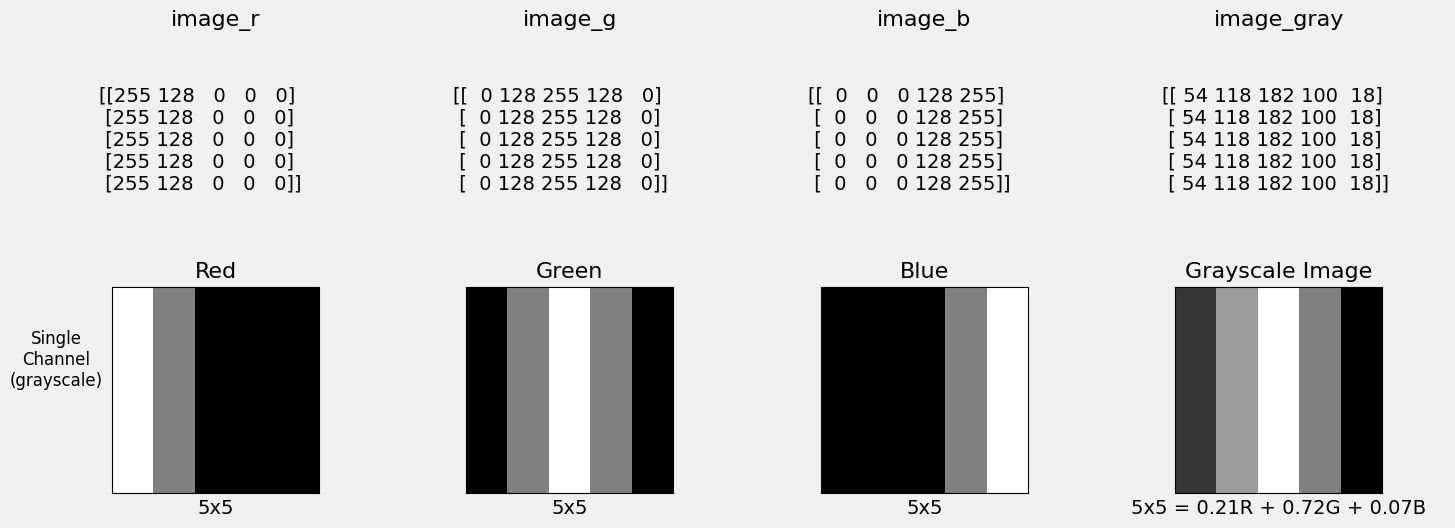

In [9]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))


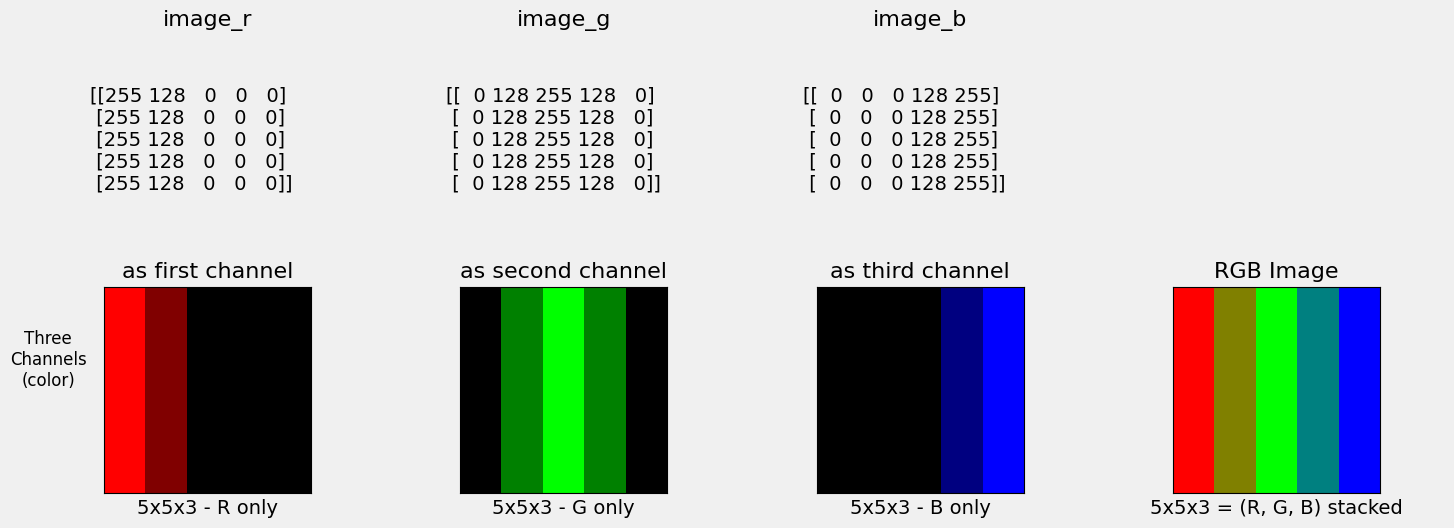

In [10]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))


## NCHW vs NHWC ##

In [11]:
images.shape

(300, 1, 5, 5)

In [12]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [13]:
example_hwc = np.transpose(example, (1,2,0))
example_hwc.shape

(5, 5, 1)

In [14]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision ##

**Transforms**

In [15]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [16]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [17]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


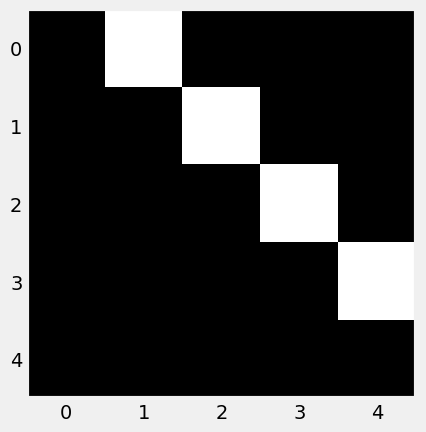

In [18]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

**Transforms on Images**

In [19]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

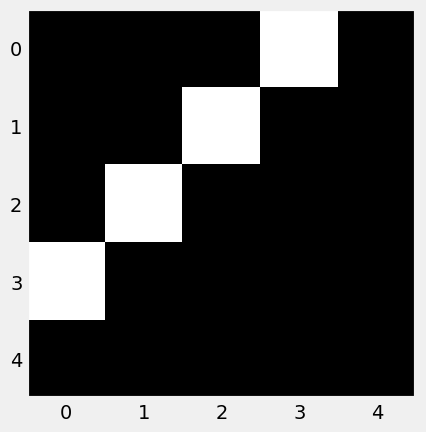

In [20]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

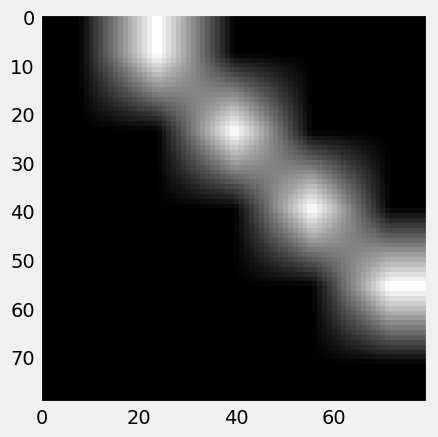

In [21]:
resize = Resize((80,80))
resized_img = resize(example_img)
plt.imshow(resized_img, cmap='gray')
plt.grid(False)

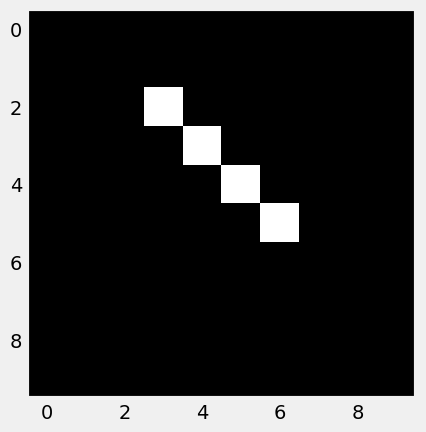

In [22]:
from torchvision.transforms import CenterCrop, RandomRotation
center_crop = CenterCrop((10,10))
center_croped_img = center_crop(example_img)
plt.imshow(center_croped_img, cmap='gray')
plt.grid(False)

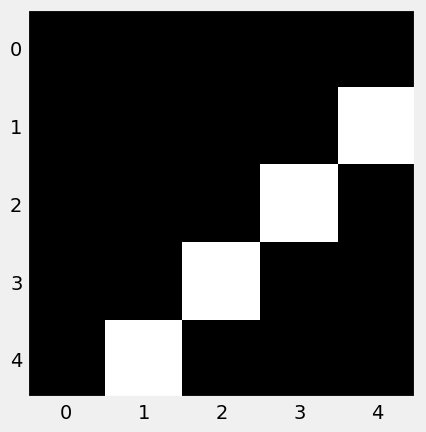

In [23]:
random_rotation = RandomRotation(degrees=(-90, 90))
random_rotated_img = random_rotation(example_img)
plt.imshow(random_rotated_img, cmap='gray')
plt.grid(False)

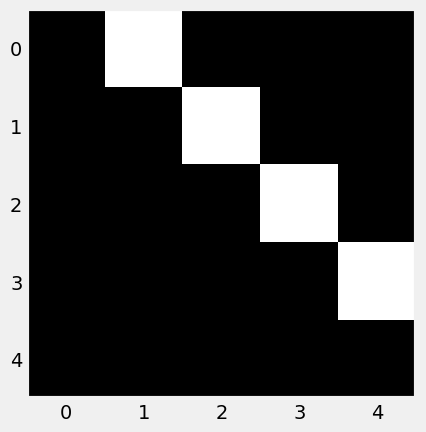

In [24]:
nor = Normalize(mean=[0.5], std=[0.5])
normalized_img = nor(example_tensor)
normalized_img_ptl = ToPILImage()(normalized_img)
plt.imshow(normalized_img_ptl, cmap='gray')
plt.grid(False)

**Transforms on Tensor**

In [25]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [26]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

**Composing Transforms**

In [27]:
composer = Compose([
    RandomHorizontalFlip(p=1.0),
    Normalize(mean=(.5,),std=(.5,) )
])

In [28]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [29]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


In [30]:
example_tensor = torch.as_tensor(example / 255).float()

## Data Preparation ##

In [31]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

**Dataset Transforms**

In [32]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x  = x
        self.y = y
        self.transform = transform
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        return x, self.y[index]
    
    def __len__(self):
        return len(self.x)

In [33]:
composer = Compose([
    RandomHorizontalFlip(p=0.5),
    Normalize(mean=(.5,), std=(.5,))
])
dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

**SubsetRandomSampler**

In [34]:
# Helper Function #4
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [35]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [36]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [37]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [38]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [39]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

**Data Augmentation Transformations**

In [40]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [41]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [42]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

**WeightedRandomSampler**

In [43]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


In [44]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [45]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [46]:
generator = torch.Generator()
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [47]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [48]:
# Helper Function #5
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [49]:
sampler = make_balanced_sampler(y_train_tensor)
sampler

**Seeds and more (seeds)**

In [50]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [51]:
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

In [52]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
    
setattr(StepByStep, 'set_seed', set_seed)

## Shallow Model ##

**Model Configuration**

In [53]:
lr = 0.1
torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)
# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()           

**Model Training**

In [54]:
n_epochs = 100
sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

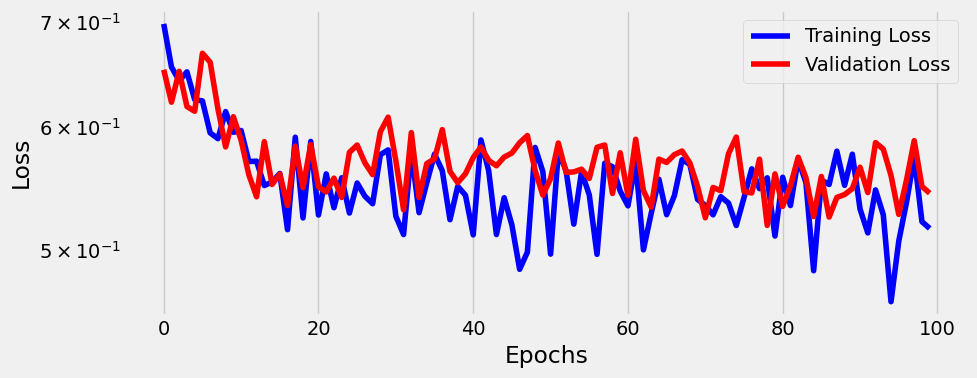

In [55]:
fig = sbs_logistic.plot_losses()

## Deep-ish Model ##

**Model Configuration**

In [56]:
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

**Model Training**

In [57]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

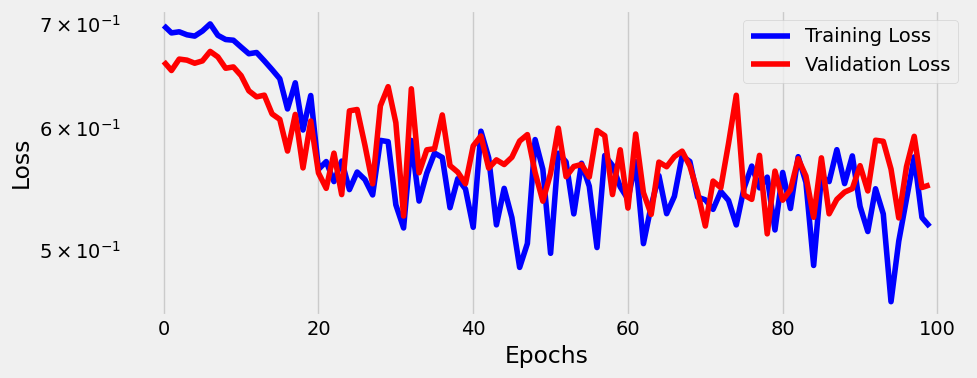

In [58]:
fig = sbs_nn.plot_losses()

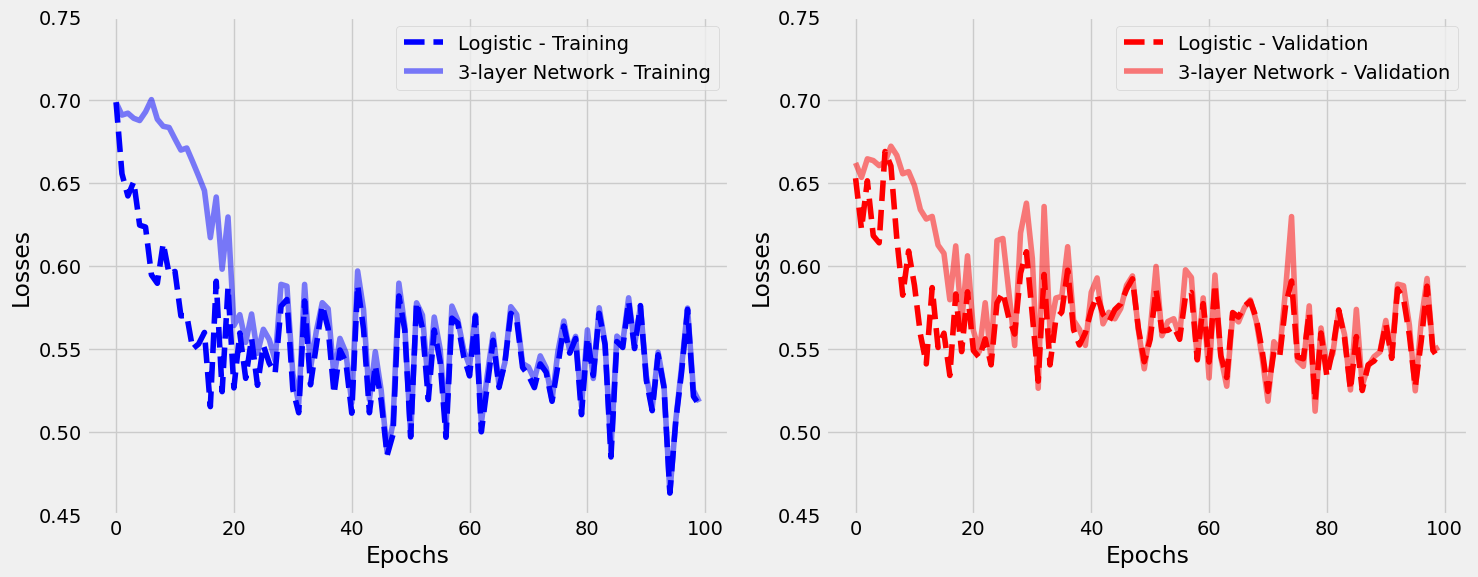

In [59]:
fig = figure5(sbs_logistic, sbs_nn)

In [60]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [61]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [62]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [63]:
w_logistic_output = model_logistic.output.weight.detach()
w_logistic_output.shape

torch.Size([1, 25])

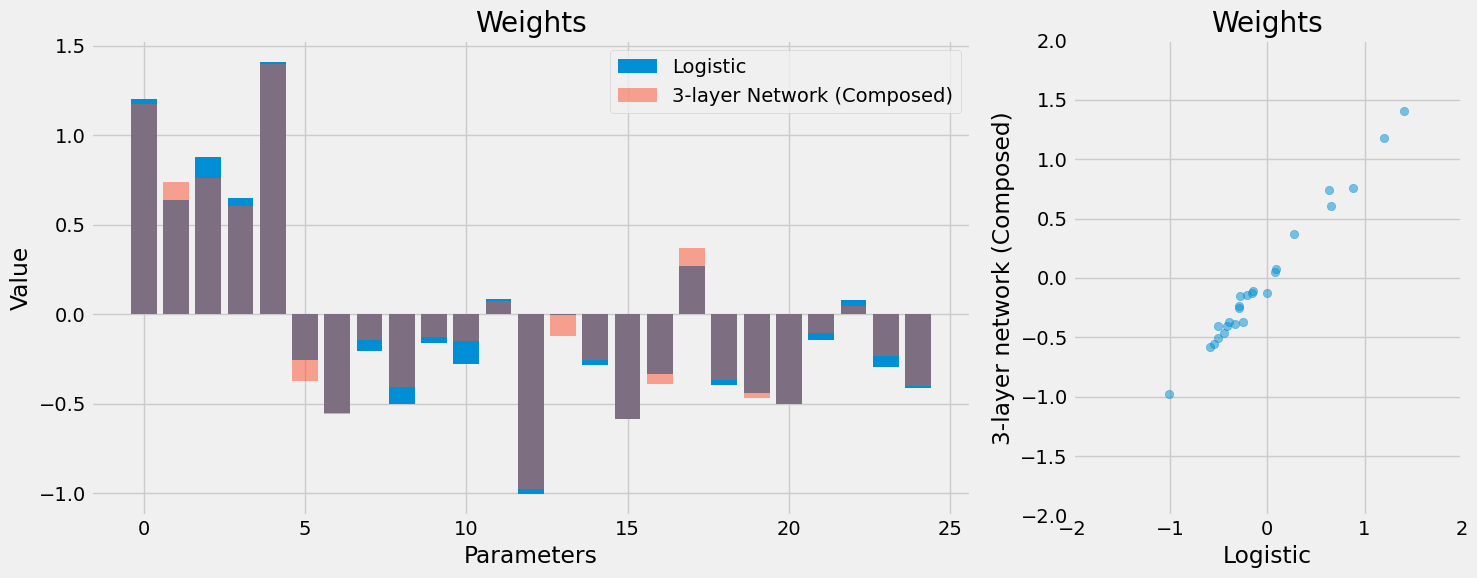

In [64]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [65]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [66]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

**Weights as Pixels**

In [67]:
w_nn_hidden0.shape

torch.Size([5, 25])

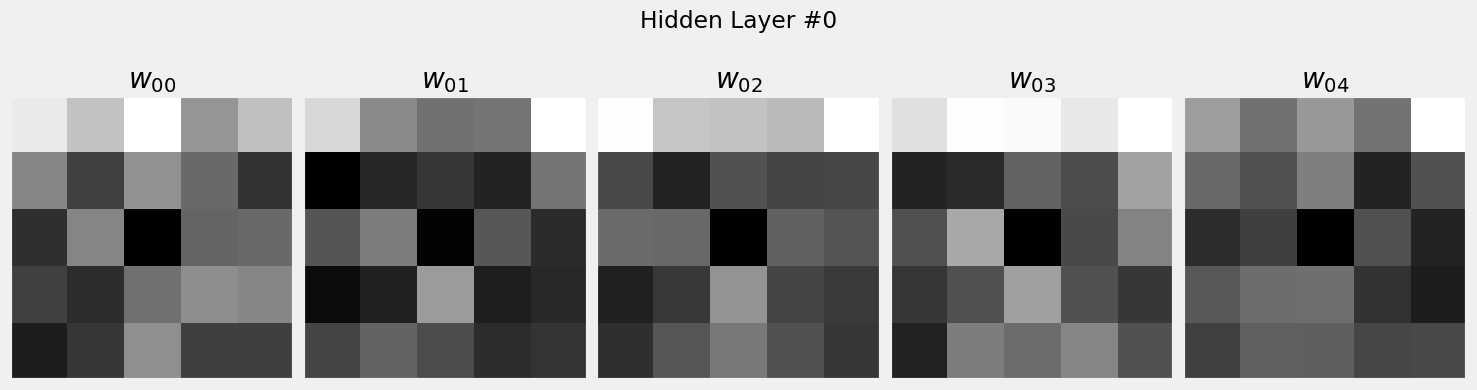

In [68]:
fig = figure7(w_nn_hidden0)

## Activation Functions ##

**Sigmoid**

/home/kazi/Works/Projects/pytorch-deep/plots/ch_4.py:182: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


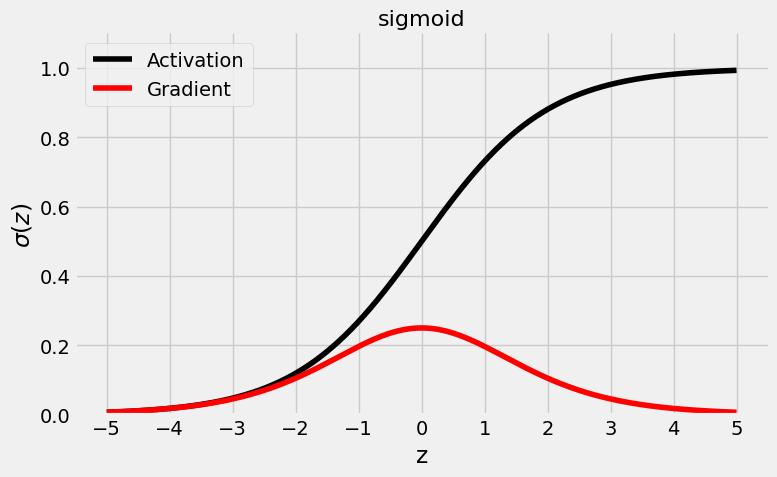

In [69]:
fig = plot_activation(torch.sigmoid)

In [70]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [71]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

**Hyperbolic Tangent (Tanh)**

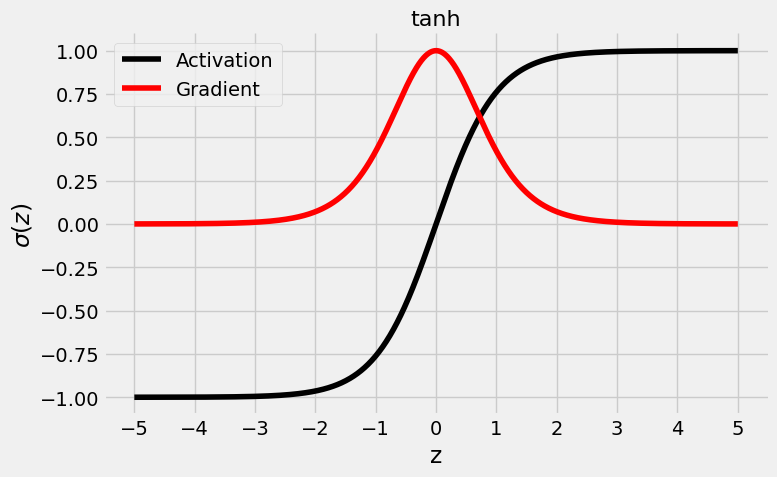

In [72]:
fig = plot_activation(torch.tanh)

In [73]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [74]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

**Rectified Linear Unit (ReLU)**

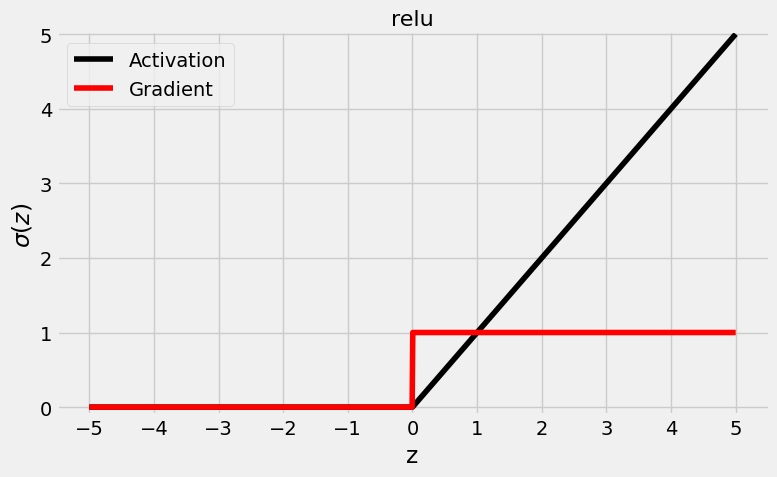

In [75]:
fig = plot_activation(torch.relu)

In [76]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [78]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [79]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

**Leaky ReLU**

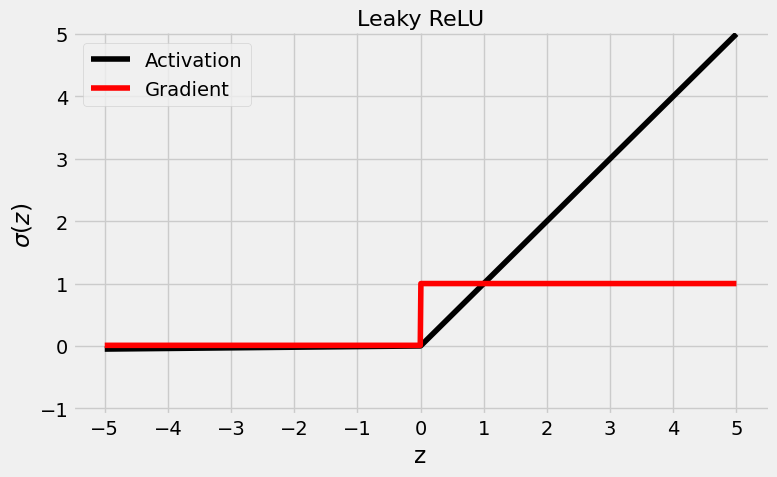

In [80]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

In [81]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [82]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

**Parametric ReLU (PReLU)**

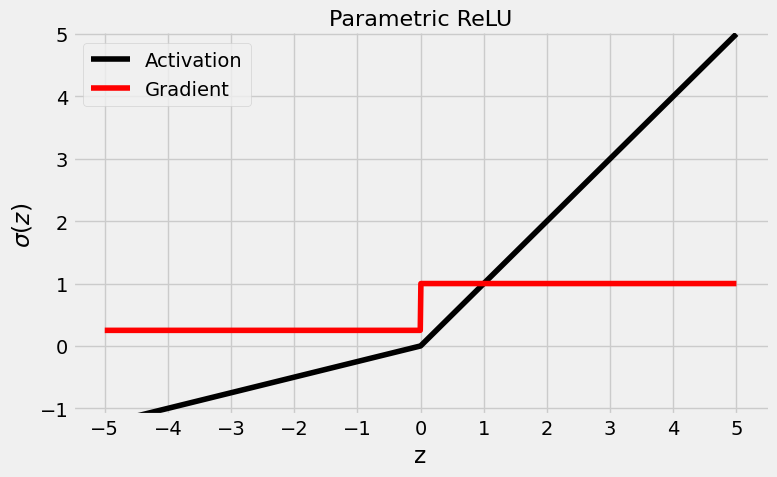

In [83]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

In [84]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

In [85]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

In [86]:
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [87]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

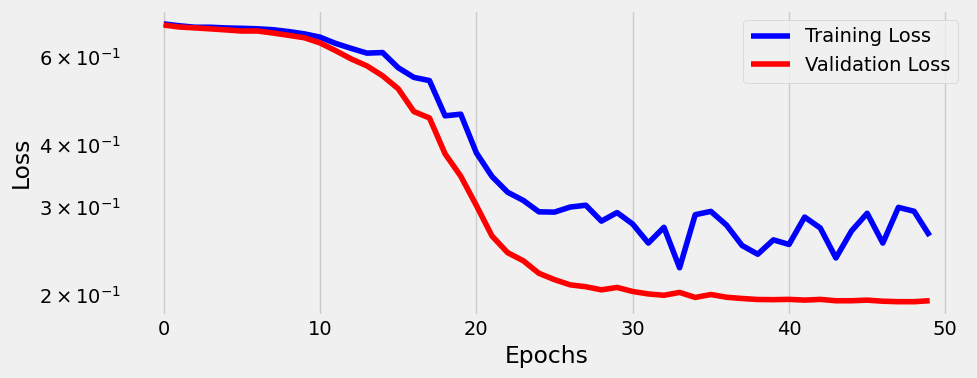

In [88]:
fig = sbs_relu.plot_losses()

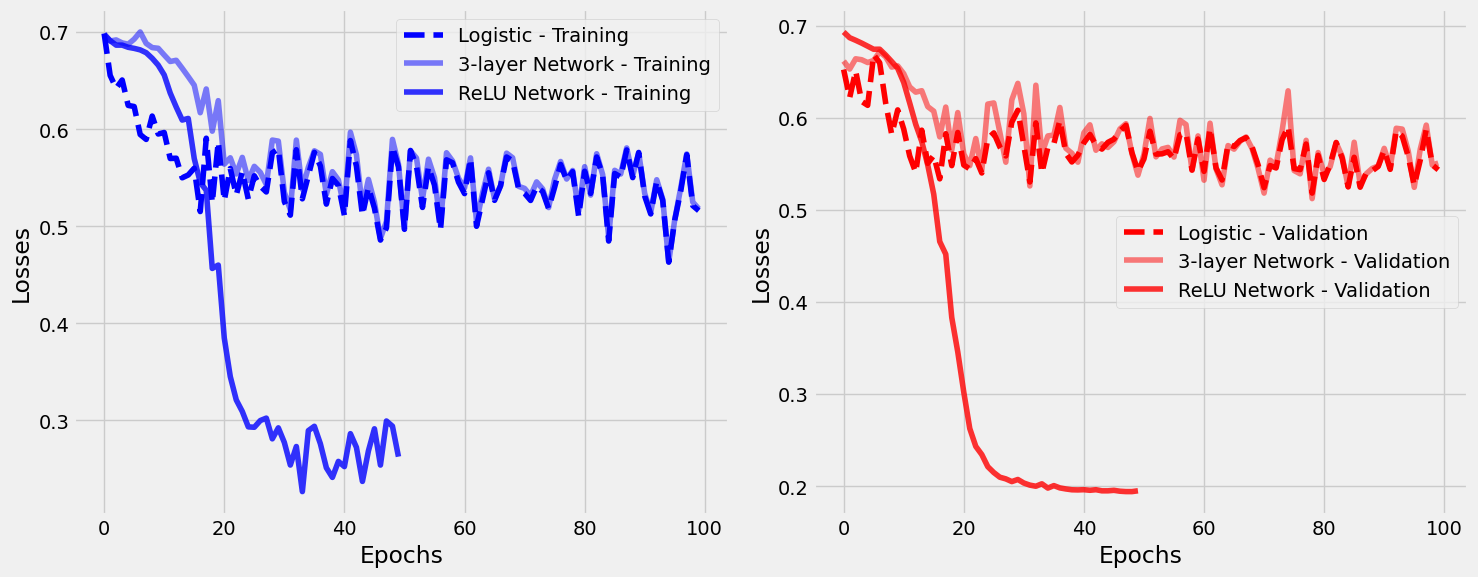

In [89]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)